## Sending the right targeted offer to Starbucks customers

For the capstone project of Udacity's Data Scientist Nanodegree Program, a simulated Starbucks dataset was provided. The dataset not only records promotional offers being sent to Starbucks customers, but also records customers' reactions to the offers, their spending record, and demographic information. 

With this rich dataset, many questions can be formed and answered. Here I focused on one single question: How can we learn from this dataset to send the right targeted offer to each customer?
    
<span style="color:#1dacd6">***This is essentially a recommender system problem, and I solved it with three scenarios in mind:***</span>
1. [<span style="color:#1dacd6">Knowing nothing about the customer</span>](#first-bullet)
2. [<span style="color:#1dacd6">Knowing transaction history of the customer</span>](#second-bullet)
3. [<span style="color:#1dacd6">Knowing both transaction history and demographic information of the customer</span>](#third-bullet)


In [282]:
import pandas as pd
import numpy as np
import json
import pickle
import collections
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 0. Load preprocessed data from pickle file
* `portfolio` - offer information
* `profile` - customer demographic information
* `transactions` - customer transactional information
* `offers` - reception/view/completion of each offer by customers

Refer to `data_cleaning_n_preprocessing.ipynb` for details of each dataframe

In [5]:
with open("data/processed_data.pickle", "rb") as f:
    portfolio, profile, transactions, offers = pickle.load(f)

## 1.  Knowing nothing about the customer<a class="anchor" id="first-bullet"></a>
If we know nothing about the customer, it is a cold start problem. I solved this problem with **a rank-based recommendation approach: send the highest-ranked offer in the dataset to the customer**. 

To rank the offers, I sorted offers in the dataset by their `view_rate` (the propotion of offers being viewed) and `complete_rate` (the propotion of offers being redeemed after being viewed), as shown below.

In [6]:
# calculate the view and complete rate of each offer type
popularity = pd.DataFrame()
popularity['count'] = offers.groupby('offer_id')['offer_id'].count()
popularity['view_rate'] = offers.groupby('offer_id')['time_viewed'].agg(lambda x:x.notna().mean())
popularity['complete_rate'] = offers.groupby('offer_id')['response'].agg(lambda x:(x==3).mean())

# merge with offer details for a more insightful look
popularity = pd.merge(popularity, portfolio, how = 'inner', on = 'offer_id')

# encode offer_type for regression
popularity = pd.concat([popularity, pd.get_dummies(popularity['offer_type'], prefix = 'type')], axis = 1)\
                    .drop('offer_type', axis = 1)

popularity

,offer_id,count,view_rate,complete_rate,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,discount_ratio,type_bogo,type_discount,type_informational
0,0,7658,0.876991,0.343301,10,10,7,0,1,1,1,0.500000,1,0,0
1,1,7593,0.961148,0.367180,10,10,5,1,1,1,1,0.500000,1,0,0
2,2,7617,0.544046,0.000000,0,0,4,1,1,1,0,0.000000,0,0,1
3,3,7677,0.543311,0.276801,5,5,7,1,1,1,0,0.500000,1,0,0
4,4,7668,0.347287,0.170970,5,20,10,1,1,0,0,0.250000,0,1,0
5,5,7646,0.959587,0.574418,3,7,7,1,1,1,1,0.428571,0,1,0
6,6,7597,0.964460,0.613927,2,10,10,1,1,1,1,0.200000,0,1,0
7,7,7618,0.877789,0.000000,0,0,3,0,1,1,1,0.000000,0,0,1
8,8,7571,0.959451,0.470083,5,5,5,1,1,1,1,0.500000,1,0,0
9,9,7632,0.539570,0.276599,2,10,7,1,1,1,0,0.200000,0,1,0


The results above shows that although all 10 offers were sent out around 7600 times, their `response_rate` ranged from 0.17 to 0.61, and their `view_rate` ranged from 0.35 to 0.96. **Offer #8, #6, and #7 are the most popular offers** among BOGO offers, discount offers, and information offers, respectively

Alternatively, if we wish to send out an offer that was not included in the dataset, we may design it by combining offer features that boost view or response rate. Below I trained two regression models for `response_rate` and `view_rate` separately. The first model provided insight into designing BOGO and discount offers (spending required), while the second one helped design informational offers (no spending required). 

channel_social       0.251
channel_web          0.081
type_discount        0.036
duration             0.029
channel_mobile       0.013
discount_ratio       0.001
channel_email        -0.000
reward               -0.004
difficulty           -0.017
type_bogo            -0.036


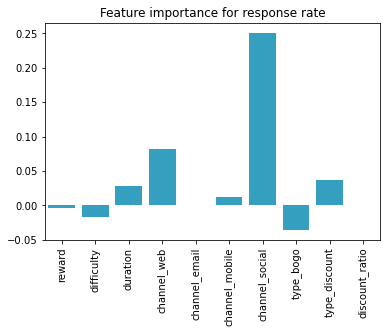

In [276]:
# model 1 - regression model for response_rate
features = ['reward', 'difficulty', 'duration', 'channel_web', 'channel_email', 'channel_mobile',\
       'channel_social', 'type_bogo', 'type_discount', 'discount_ratio']
X = popularity[popularity['type_informational']==0][features]
y = popularity[popularity['type_informational']==0]['complete_rate']

model = LinearRegression()
model.fit(X,y)
feature_importances = model.coef_

for feature,importance in sorted(zip(features,feature_importances), key = lambda x:x[1], reverse=True):
    print('{: <20} {:.3f}'.format(feature, importance))
    
sns.barplot(x = features, y = feature_importances, color="#1dacd6")
plt.xticks(rotation=90)
plt.title('Feature importance for response rate');

channel_social       0.419
channel_mobile       0.196
channel_web          0.083
duration             0.000
channel_email        -0.000


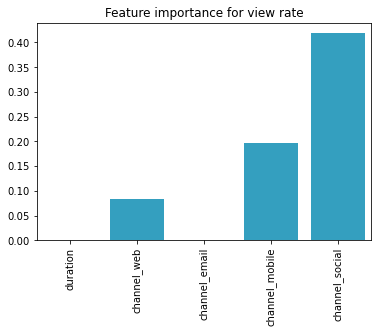

In [275]:
# model 2 - regression model for view_rate
features = ['duration', 'channel_web', 'channel_email', 'channel_mobile', 'channel_social']
X = popularity[features]
y = popularity['view_rate']

model = LinearRegression()
model.fit(X,y)
feature_importances = model.coef_

for feature,importance in sorted(zip(features,feature_importances), key = lambda x:x[1], reverse=True):
    print('{: <20} {:.3f}'.format(feature, importance))
    
sns.barplot(x = features, y = feature_importances, color="#1dacd6")
plt.xticks(rotation=90)
plt.title('Feature importance for view rate');

The feature importances derived from the first model showed that **promotion channels played the biggest role in response rate**. People responded strongly and positively to offers received via social media and web, and slightly positively to offers received via mobile app. Longer promotion duration and less difficulty (minumum spending requirement) improved response rate, as expected. The reward and its ratio to difficulty, surprisingly, did not seem so important. Between BOGO and discount offers, people preferred the latter.

The feature importances derived from the second model showed that **promotion channels also played the biggest role in view rate**. People were mostly likely to view an offer sent via social media, followed by mobile app and web. The duration of the offer has minimal impact on the view rate. 

<span style="color:#1dacd6">***Based on the above findings, here are my strategies for sending offers to new customers:***</span>
* <span style="color:#1dacd6">Send the customer Offer #8 for BOGO offer, Offer #6 for discount offer, and Offer #7 for information offer.</span>
* <span style="color:#1dacd6">Alternatively, if one wish to design a new offer from scratch, make sure it was promoted via both social media and web channels. Run the promotion for a longer period if possible, and design it as a discount-type offer with low minimum purchase requirement. </span>

## 2. Knowing transaction history of the customer<a class="anchor" id="second-bullet"></a>
If we know the transaction history (offer redemptions and spending records) of the customer, we can do a better job recommending new offers to the customer.  

Here I used a **model-based collaborative filtering approach**, which modeled the user-item interactions (in this case, customer-offer interactions) and used the model to predict new offers that the customer might be interested in.

### 2.1 Model-based collaborative filtering (FunkSVD)
The model-based collaborative filtering method I used is **FunkSVD**. It decomposed the user-item matrix (a matrix of customer-offer interactions) into a user-latent matrix and a latent-item matrix. The latent spaces were hiden features of customers and offers, which could be used to predict a customer's response to an unseen offer. The matrix decomposition was performed iteratively, with regularizations added to the objective function to reduce overfitting:
<img src="objective_func.png" alt="objective function" width="600"/>

Below I defined the FunkSVD class as a child class of Sklearn's regressor template, so that it can safely interact with Sklearn's pipeline and other model selection tools. The class has three functionalities: **fitting a model by decomposing the user-item matrix, predicting a customer's response to an offer according to the model, and recommending new offers to the customer according to the predictions**.  

In [301]:
class FunkSVD(BaseEstimator, RegressorMixin):

    def __init__(self, latent_features=4, learning_rate=0.001, decay = 1, lam = 0, \
                 iters=100, early_stopping = True, verbose = 0, plot = 0):
        self.latent_features = latent_features
        self.learning_rate = learning_rate
        self.decay = decay
        self.lam = lam
        self.iters = iters
        self.early_stopping = early_stopping
        self.verbose = verbose
        self.plot = plot

        
    def fit(self, X, y):
        # generate user-item matrix (pivot matrix)
        self.user_ids, user_pos = np.unique(X[:, 0], return_inverse=True) 
        self.item_ids, item_pos = np.unique(X[:, 1], return_inverse=True)    
        self.user_pos_lut = {self.user_ids[i]:i for i in range(len(self.user_ids))} # id -> idx
        self.item_pos_lut = {self.item_ids[i]:i for i in range(len(self.item_ids))}
        n_users, n_items, n_ratings = len(self.user_ids), len(self.item_ids), len(y)
        self.user_item = np.empty((n_users, n_items))
        self.user_item[:] = np.nan
        self.user_item[user_pos, item_pos] = y 

        # initialize the user-latent and latent-item matrices with random values
        self.user_mat = np.random.rand(n_users, self.latent_features)
        self.item_mat = np.random.rand(self.latent_features, n_items)

        losses = []
        for iteration in range(self.iters):
            loss = 0 # mse loss + regularizations
            mse = 0 # mse loss

            # For each user-item pair
            for i in range(n_users):
                for j in range(n_items):                               
                    # if the rating exists
                    if not np.isnan(self.user_item[i, j]):                    
                        # compute the error
                        y_pred = np.dot(self.user_mat[i, :], self.item_mat[:, j])
                        y = self.user_item[i, j]
                        diff = y_pred - y
                        loss += 0.5*diff**2
                        mse += 0.5*diff**2

                        # update the values in the opposite direction of the gradient
                        for k in range(self.latent_features):                            
                            prev_user_dp, prev_item_dp = self.user_mat[i, k], self.item_mat[k, j]
                            self.user_mat[i, k] -= self.learning_rate * \
                                                (diff*prev_item_dp + self.lam*prev_user_dp)
                            self.item_mat[k, j] -= self.learning_rate * \
                                                (diff*prev_user_dp + self.lam*prev_item_dp) 
                            loss += 0.5*self.lam*(prev_user_dp**2 + prev_item_dp**2)                
            loss /= n_ratings
            mse /= n_ratings
            
            # reduce learning rate
            if iteration%10==0:
                self.learning_rate *= self.decay
            
            # record and show results for this iteration
            losses.append(loss)
            if self.verbose>1 and iteration%10==0:
                print("Iteration{:03d}, Loss:{:.3f}, MSE:{:.3f} ".format(iteration, loss, mse))
                
            # early stopping
            if self.early_stopping and len(losses)>1 and (losses[-2]-losses[-1])<1e-4:
                if self.verbose>0:
                    print("Early stopping at Iteration{:03d}.format(iteration)")
                break

        # show overall results
        if self.plot>0:
            plt.plot(losses)
            plt.ylabel('Loss')
            plt.xlabel('Iteration')
            plt.show()
        if self.verbose>0:
            print('Final Lose:{}, Final MSE:{}'.format(loss, mse))
        
        return self

    
    def predict(self, X):
        y_pred = []
        for user_id, item_id in X:
            # assert both user and item have been seen
            if user_id in self.user_pos_lut:
                user_idx = self.user_pos_lut[user_id]
            else:
                raise Exception('Cannot predict unseen user {}'.format(user_id))               
            if item_id in self.item_pos_lut:
                item_idx = self.item_pos_lut[item_id]
            else:
                raise Exception('Cannot predict unseen item {}'.format(item_id)) 
            
            # make prediction
            y_pred.append(self.user_mat[user_idx,:].dot(self.item_mat[:,item_idx]))
            
        return y_pred  
    
    
    def make_recommendations(self, user_id, n_candidate = -1): 
        '''
        make recommendations based on predicted ratings
        '''
        # if n_candidate = -1, recommend all unseen items
        if n_candidate == -1:
            n_candidate = self.user_item.shape[1]
        
        # predict ratings for all items
        ratings = []
        for item_id in self.item_ids:
            y_pred = self.predict(np.array([[user_id, item_id]]))
            ratings.append((y_pred, item_id))
        ratings_sorted = sorted(ratings, reverse=True) 
        
        # choose the top rated unseen items
        candidates = []
        user_idx = self.user_pos_lut[user_id]
        for rating, item_id in ratings_sorted:
            item_idx = self.item_pos_lut[item_id]
            if len(candidates) < n_candidate and np.isnan(self.user_item[user_idx, item_idx]):
                candidates.append(item_id)

        return candidates
    

### 2.2 Train-test split
To test the performance of the model, the `offers` dataframe was splitted into training and test datasets using a custom splitter `test_fold_FunkSVD`.

Note that FunkSVD cannot handle unseen customers, so the function ensured that **each customer had at least one entry in the training dataset**. The same splitter was also used for cross-validation later.

In [173]:
def test_fold_FunkSVD(X, test_size = 0.1, fold = 1, random_state = 42):
    '''
    generate train/test indices for splitting data into train/test sets
    to avoid cold start problem, make sure the training set has at least one record of each user
    '''
    np.random.seed(random_state)

    if isinstance(test_size, int):
        n = test_size
    elif isinstance(test_size, float):
        n = max(int(X.shape[0]*test_size),1)

    # count of data entry for each user 
    record_count = collections.Counter(X[:,0])
    
    candidates = list(np.random.permutation(X.shape[0]))
    test_fold = np.array([-1]*X.shape[0])
    for i in range(fold):
        test_idx = []
        while len(test_idx) < n:
            assert len(candidates) > 0
            candidate = candidates.pop()
            candidate_user_id = X[candidate,0]
            if record_count[candidate_user_id] > 1:
                record_count[candidate_user_id] -= 1
                test_idx.append(candidate)
        test_fold[test_idx] = i
                
    return test_fold


In [306]:
X = offers[['customer_id','offer_id']].to_numpy()
y = offers['response'].to_numpy()

# train/test split
test_fold = test_fold_FunkSVD(X, test_size = 0.01, fold = 1, random_state = 42)
ps = PredefinedSplit(test_fold)
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(75515, 2) (75515,) (762, 2) (762,)


### 2.3 Hyper-parameter tuning and testing
The hyper-parameters of FunkSVD model were tuned with **grid search and cross-validations, using MSE as evaluation metric**. After tuning, the best model (model with minimum cross-validation MSE) was further tested with the test dataset, also using MSE as metric.

In [ ]:
# parameters to be tuned
params = {
    'latent_features':[2,4], 
    'learning_rate':[0.1,0.05,0.01], 
    'decay':[0.7,0.5],
    'lam' : [0.2,0.5], 
    'iters':[200]
}

# grid search with cross-validation
funk_svd = FunkSVD(verbose = 1, plot = 0)
cv_fold = test_fold_FunkSVD(X_train, test_size = 200, fold = 3, random_state = 42)
clf = GridSearchCV(funk_svd, params, cv = PredefinedSplit(cv_fold),\
                   verbose = 3, scoring = 'neg_mean_squared_error', n_jobs = 1)
clf.fit(X_train, y_train)
clf.best_params_

In [231]:
# test the performance of the optimized model
best = clf.best_estimator_
y_pred = best.predict(X_test)
print('MSE of the test dataset: {:.03f}'.format(mean_squared_error(y_pred, y_test)))

MSE of the test dataset: 0.983


### 2.4 Making recommendations using the FunkSVD model
After finding the best set of hyper-parameters, the model was re-trained with all data available. To recommende offers to an customer, **the model predicts his/her response to all unseen offers, and offers with top responses are recommended**.

Iteration000, Loss:0.792, MSE:0.507 
Iteration010, Loss:0.740, MSE:0.444 
Iteration020, Loss:0.711, MSE:0.413 
Iteration030, Loss:0.687, MSE:0.387 
Iteration040, Loss:0.668, MSE:0.366 
Iteration050, Loss:0.652, MSE:0.349 
Iteration060, Loss:0.639, MSE:0.335 
Iteration070, Loss:0.628, MSE:0.323 
Iteration080, Loss:0.619, MSE:0.314 
Iteration090, Loss:0.611, MSE:0.306 
Iteration100, Loss:0.605, MSE:0.300 
Iteration110, Loss:0.599, MSE:0.294 
Iteration120, Loss:0.594, MSE:0.290 
Iteration130, Loss:0.590, MSE:0.286 
Iteration140, Loss:0.587, MSE:0.283 
Iteration150, Loss:0.584, MSE:0.280 
Iteration160, Loss:0.581, MSE:0.277 
Iteration170, Loss:0.579, MSE:0.275 
Iteration180, Loss:0.577, MSE:0.273 
Iteration190, Loss:0.575, MSE:0.272 


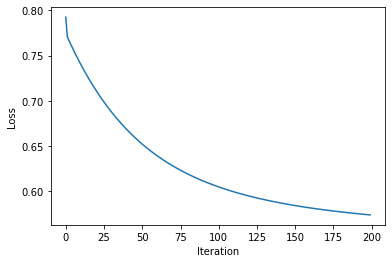

Final Lose:0.5736762770261985, Final MSE:0.2706843856163637
The top 3 offers recommended for User 0 are: 8, 1, 0


In [314]:
svd = FunkSVD(**clf.best_params_, plot = 0, verbose = 0)
svd.fit(X,y)

# recommend 3 offers for user 0
user_id = 0
n_candidate = 3
offer_candidates = svd.make_recommendations(user_id = user_id, n_candidate = n_candidate)
print('The top {} offers recommended for User {} are: {}'\
      .format(n_candidate, user_id, ', '.join(str(candidate) for candidate in offer_candidates)))

### 2.5 But wait a minute ... are offers really necessary for all customers?
Offers are sent out to motive cutomer spendings, but what if a customer has massive spending anyway? 

**If a customer was spending way more money than what was required to complete his/her offers, this customer may not need offers at all.** Since we have the customers' transaction history, let's find out those customers.

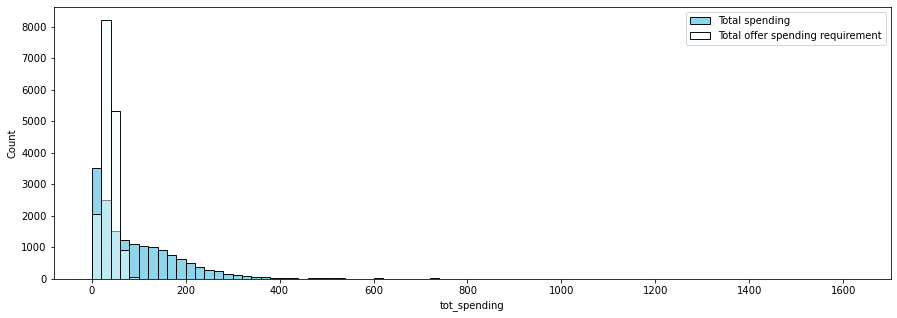

In [296]:
# total spending of each customer
spending_vs_requirement = transactions.groupby('customer_id')['amount'].sum().reset_index(name = 'tot_spending')

# total offer minimum spending requirements of each customer
spending_vs_requirement['tot_requirement'] = pd.merge(offers, portfolio, how = 'left', on = 'offer_id')\
                            .groupby('customer_id')['difficulty'].sum()

# plot distributions of spendings vs requirements
plt.figure(figsize=(15,5))
sns.histplot(spending_vs_requirement['tot_spending'], binwidth=20, color="#1dacd6", alpha = 0.5, \
             label = 'Total spending')
sns.histplot(spending_vs_requirement['tot_requirement'], binwidth=20, color="azure", alpha = 0.5, \
             label = 'Total offer spending requirement')
plt.legend();

As we see above, the distribution of total spending is highly skewed, while the distrution of the total offer spending requirement is close to normal. Below I fitted a normal distribution to the total offer spending requirement, and set a hard threshold at 5 sigmas. **Customers who spent beyond the threshold are considered spending way more money than required, therefore insensitive to offers.**

In [309]:
# find threshold
mu, std = norm.fit(spending_vs_requirement['tot_requirement'].dropna())
threshold = 5*std + mu
print('miu = {:.02f} \nsigma = {:.02f} \nthreshold = {:.02f}'.format(mu, std, threshold))

# find offer-sensitive customers
spending_vs_requirement['offer_sensitive'] = spending_vs_requirement['tot_spending'] <= threshold
spending_vs_requirement.head()

miu = 34.61 
sigma = 14.33 
threshold = 106.25


,customer_id,tot_spending,tot_requirement,offer_sensitive
0,0,20.40,57.0,True
1,1,77.01,5.0,True
2,2,14.30,5.0,True
3,3,159.27,20.0,False
4,4,4.65,60.0,True


<span style="color:#1dacd6">***Based on the above findings, here are my strategies for sending offers to customers with transaction histories:***</span>
* <span style="color:#1dacd6">If in the past the customer had spent way more money than the offer required, this is a customer insensitive to offers. No more offer needs to be sent.</span>
* <span style="color:#1dacd6">Otherwise, use the FunkSVD model to predict the customer's response to offers he/she has not received before, and send him/her offers with the highest responses. </span>

## 3. Knowing transaction history & demographic information of the customer<a class="anchor" id="third-bullet"></a>
demographic information about the customer (age, gender, etc.)

a hybrid approach of collaborative filtering and content-based.

## 4. Conclusion